# Dike Model Multi-Objective Analysis

In [1]:
# import libraries
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario, save_results,
)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\nelen\EPA141A\venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


## 1) Problem formulation

In [3]:
if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)

    model, steps = get_model_for_problem_formulation(3)

    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)

    convergence_metrics = [EpsilonProgress()]
    #determine epsilon
    epsilon = [1e3] * len(model.outcomes)
    #epsilon = [0.125, 0.05, 0.01, 0.01]
    nfe = 5000  # proof of principle only, way to low for actual use
    #multiprocessing
    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=epsilon,
            convergence=convergence_metrics,
            reference=ref_scenario,
        )
    #save results
    #save_results((results, convergence), 'results/dikeoptimization_problem3_test.tar.gz')

[MainProcess/INFO] pool started with 8 workers
5082it [14:31,  5.83it/s]                                                      
[MainProcess/INFO] optimization completed, found 366 solutions
[MainProcess/INFO] terminating pool


In [7]:
#load results
#results1, convergence1 = load_results('results/dikeoptimization_problem3.tar.gz')

## 2) Searching for candidate solutions

### Assessing epsilon values

Because there are more than 3 outcomes of interest, results are visualized  using a parallel coordinate plot. (From the course material) -> In a parallel coordinate plot, the dimensions are visualized side by side. A line connecting the dimensions is a single point in the multidimensional space. For more than 3 dimensions, parallel coordiante plots are prefered over 3d scatter plots with additional visual encodings for the other dimensions.

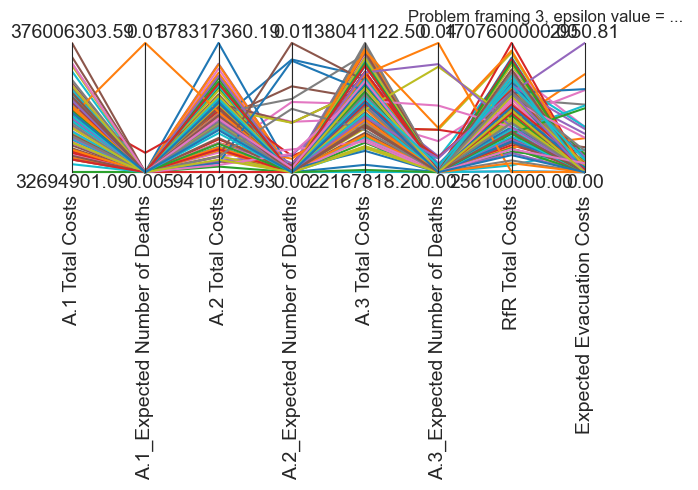

In [34]:
outcomes = results.loc[:, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths','RfR Total Costs', 'Expected Evacuation Costs']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.title("Problem framing 3, epsilon value = ... ")
#plt.savefig('./images/multi_obj_problem3_epsilon_test.png')
plt.show()

### Assessing the number of function evaluations (convergence)

In [4]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem

def calculate_metrics(archives, reference_set):
    problem = to_problem(model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

In [5]:
from ema_workbench.em_framework.optimization import ArchiveLogger

#archives = ArchiveLogger.load_archives(f"./archives/tutorial.tar.gz")
reference_set = archives[max(archives.keys())] # this is the final archive

metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\nelen\\EPA141A\\final assignment\\archives\\tutorial.tar.gz'

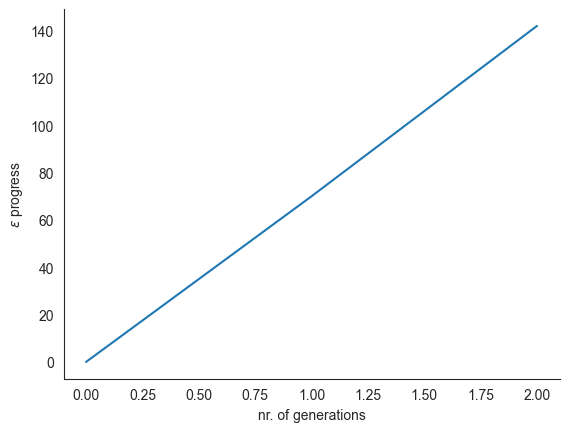

In [36]:
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel("nr. of generations")
ax1.set_ylabel(r"$\epsilon$ progress")
sns.despine()

### Assessing tradeoffs and conflicting objectives

## 3) Re-evaluate candidate solutions under uncertainty

### Applying constraints

#### Defining constraints

#### Applying constraints on the results

#### Running reduced-size solution set of policies

In [10]:
### Evaluating robustness

#### Determining robustness metrics

- Signal to noise
- maximum regret?

#### Plotting robustness tradeoffs

## 4) Assessing the uncertain conditions under which we get poor performance